# compose

In [1]:
import pandas as pd
from util import plot_scores

# warnings
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore",
                        category=UserWarning)  # hide: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [2]:
def compose_all(inputs, output=None, models_to_keep=None, attributes_to_keep=None):
    """
    Compose all the data from the different models into one file
    :param inputs: Array of score csv files to combine
    :param output: Output file
    :param models_to_keep: List of strings containing the names of the models to keep (of None, keep all)
    :param attributes_to_keep: Dict of list where the key is a column name and the value is a list of values to keep
    :return:
    """
    if models_to_keep is not None:
        attributes_to_keep = {} if attributes_to_keep is None else attributes_to_keep
        attributes_to_keep['model'] = models_to_keep

    df = pd.DataFrame()

    for i in inputs:
        df = pd.concat([df, pd.read_csv(i)])

    if attributes_to_keep is not None:
        for key, value in attributes_to_keep.items():
            df = df[df[key].isin(value)]

        # sort in the order of the (categorical) lists in attributes_to_keep
        df = df.sort_values(by=list(attributes_to_keep.keys()))

    df.to_csv(output, index=False) if output is not None else None

    return df

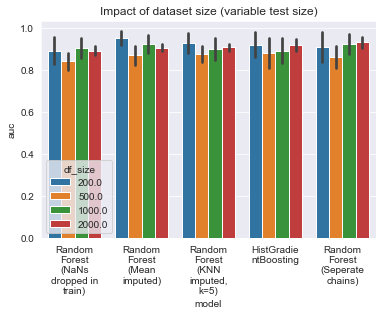

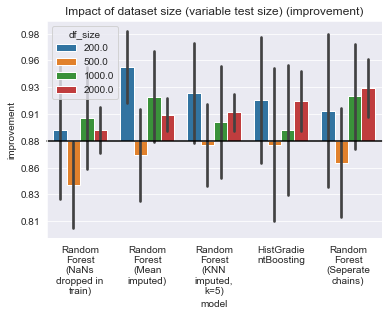

In [3]:
title = "Impact of dataset size (variable test size)"
df = compose_all(['outputs/model-evaluations-20230518-125400-GILGFVFTL-200/scores-20230518-125447.csv',
                  'outputs/model-evaluations-20230518-125507-GILGFVFTL-500/scores-20230518-125701.csv',
                  'outputs/model-evaluations-20230518-125813-GILGFVFTL-1000/scores-20230518-130302.csv',
                  'outputs/model-evaluations-20230518-130554-GILGFVFTL-2000/scores-20230518-131925.csv'],
                 'composed_data/GILGFVFTL-different-sizes.csv',
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (KNN imputed, k=5)",
                     "HistGradientBoosting",
                     "Random Forest (Seperate chains)"
                 ])
plot_scores(df, title, hue="df_size", wrap=True)

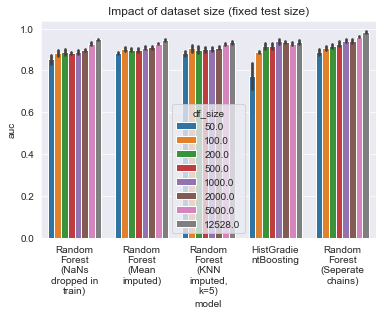

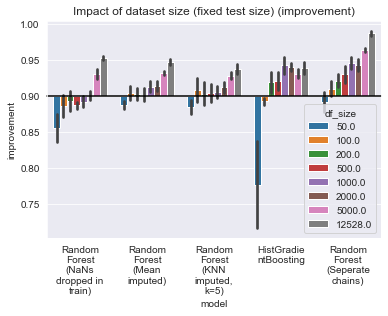

In [4]:
title = "Impact of dataset size (fixed test size)"
# Disclaimer: same test set was (accidentaly) used for all of the 5 folds, training set was different per fold
df = compose_all(['outputs/model-evaluations-20230519-223940-GILGFVFTL-50-fixed-test-size/scores-20230519-224017.csv',
                  'outputs/model-evaluations-20230519-223724-GILGFVFTL-100-fixed-test-size/scores-20230519-223817.csv',
                  'outputs/model-evaluations-20230518-133505-GILGFVFTL-200-fixed-test-size/scores-20230518-133605.csv',
                  'outputs/model-evaluations-20230518-133659-GILGFVFTL-500-fixed-test-size/scores-20230518-133906.csv',
                  'outputs/model-evaluations-20230518-134125-GILGFVFTL-1000-fixed-test-size/scores-20230518-134633.csv',
                  'outputs/model-evaluations-20230518-134717-GILGFVFTL-2000-fixed-test-size/scores-20230518-140119.csv',
                  'outputs/model-evaluations-20230519-011756-GILGFVFTL-5000-fixed-test-size/scores-20230519-024251.csv',
                  'outputs/model-evaluations-20230519-090347-GILGFVFTL-12528-fixed-test-size/scores-20230519-202428.csv'],
                 'composed_data/GILGFVFTL-different-sizes-fixed-test-size.csv',
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (KNN imputed, k=5)",
                     "HistGradientBoosting",
                     "Random Forest (Seperate chains)"
                 ])
plot_scores(df, title, hue="df_size", wrap=True)

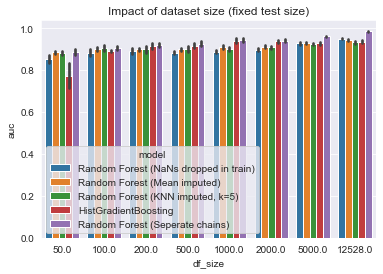

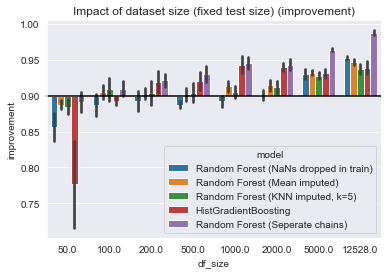

In [5]:
plot_scores(df, title, wrap=True, x="df_size", hue="model")

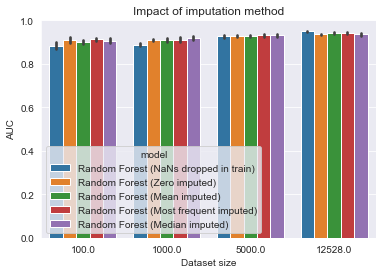

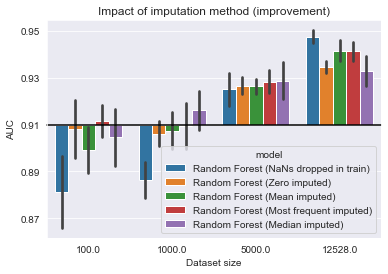

In [7]:
title = "Impact of imputation method"

df = compose_all(['outputs/model-evaluations-20230519-223724-GILGFVFTL-100-fixed-test-size/scores-20230519-223817.csv',
                  'outputs/model-evaluations-20230518-134125-GILGFVFTL-1000-fixed-test-size/scores-20230518-134633.csv',
                  'outputs/model-evaluations-20230519-011756-GILGFVFTL-5000-fixed-test-size/scores-20230519-024251.csv',
                  'outputs/model-evaluations-20230519-090347-GILGFVFTL-12528-fixed-test-size/scores-20230519-202428.csv'],
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Zero imputed)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (Most frequent imputed)",
                     "Random Forest (Median imputed)"
                 ])

output = 'graphs/GILGFVFTL-simple-imputation-methods.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

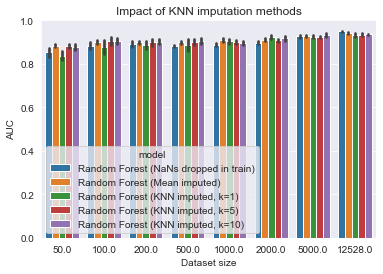

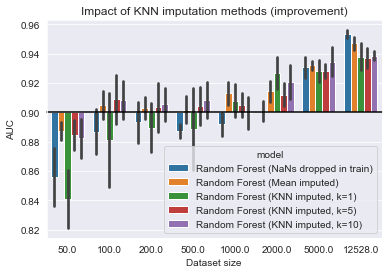

In [10]:
title = "Impact of KNN imputation methods"

df = compose_all(['outputs/model-evaluations-20230519-223940-GILGFVFTL-50-fixed-test-size/scores-20230519-224017.csv',
                  'outputs/model-evaluations-20230519-223724-GILGFVFTL-100-fixed-test-size/scores-20230519-223817.csv',
                  'outputs/model-evaluations-20230518-133505-GILGFVFTL-200-fixed-test-size/scores-20230518-133605.csv',
                  'outputs/model-evaluations-20230518-133659-GILGFVFTL-500-fixed-test-size/scores-20230518-133906.csv',
                  'outputs/model-evaluations-20230518-134125-GILGFVFTL-1000-fixed-test-size/scores-20230518-134633.csv',
                  'outputs/model-evaluations-20230518-134717-GILGFVFTL-2000-fixed-test-size/scores-20230518-140119.csv',
                  'outputs/model-evaluations-20230519-011756-GILGFVFTL-5000-fixed-test-size/scores-20230519-024251.csv',
                  'outputs/model-evaluations-20230519-090347-GILGFVFTL-12528-fixed-test-size/scores-20230519-202428.csv'],
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (KNN imputed, k=1)",
                     'Random Forest (KNN imputed, k=5)',
                     'Random Forest (KNN imputed, k=10)',
                     "Random Forest (Mean imputed)",
                 ])

output = 'graphs/GILGFVFTL-knn-imputation-methods.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

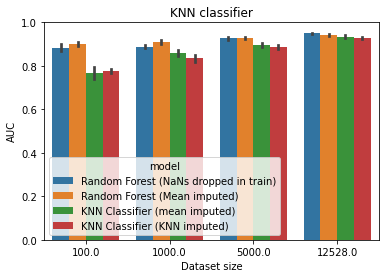

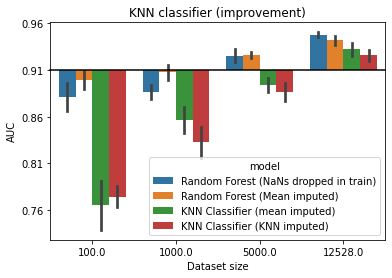

In [3]:
title = "KNN classifier"

df = compose_all(['outputs/model-evaluations-20230519-223724-GILGFVFTL-100-fixed-test-size/scores-20230519-223817.csv',
                  'outputs/model-evaluations-20230518-134125-GILGFVFTL-1000-fixed-test-size/scores-20230518-134633.csv',
                  'outputs/model-evaluations-20230519-011756-GILGFVFTL-5000-fixed-test-size/scores-20230519-024251.csv',
                  'outputs/model-evaluations-20230519-090347-GILGFVFTL-12528-fixed-test-size/scores-20230519-202428.csv'],
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "KNN Classifier (mean imputed)",
                     "KNN Classifier (KNN imputed)"
                 ])

output = 'graphs/GILGFVFTL-knn-classifier.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

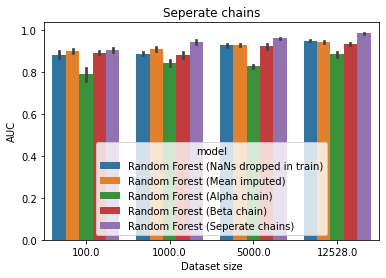

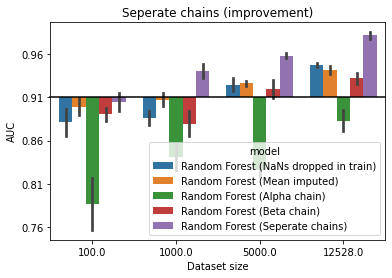

In [4]:
title = "Seperate chains"

df = compose_all(['outputs/model-evaluations-20230519-223724-GILGFVFTL-100-fixed-test-size/scores-20230519-223817.csv',
                  'outputs/model-evaluations-20230518-134125-GILGFVFTL-1000-fixed-test-size/scores-20230518-134633.csv',
                  'outputs/model-evaluations-20230519-011756-GILGFVFTL-5000-fixed-test-size/scores-20230519-024251.csv',
                  'outputs/model-evaluations-20230519-090347-GILGFVFTL-12528-fixed-test-size/scores-20230519-202428.csv'],
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (Alpha chain)",
                     "Random Forest (Beta chain)",
                     "Random Forest (Seperate chains)"
                 ])

output = 'graphs/GILGFVFTL-seperate-chains.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

In [ ]:
title = "Seperate chains"

df = compose_all(['outputs/model-evaluations-20230519-223724-GILGFVFTL-100-fixed-test-size/scores-20230519-223817.csv',
                  'outputs/model-evaluations-20230518-134125-GILGFVFTL-1000-fixed-test-size/scores-20230518-134633.csv',
                  'outputs/model-evaluations-20230519-011756-GILGFVFTL-5000-fixed-test-size/scores-20230519-024251.csv',
                  'outputs/model-evaluations-20230519-090347-GILGFVFTL-12528-fixed-test-size/scores-20230519-202428.csv'],
                 None,
                 models_to_keep=[
                     "Random Forest (NaNs dropped in train)",
                     "Random Forest (Mean imputed)",
                     "Random Forest (Alpha chain)",
                     "Random Forest (Beta chain)",
                     "Random Forest (Seperate chains)"
                 ])

output = 'graphs/GILGFVFTL-seperate-chains.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

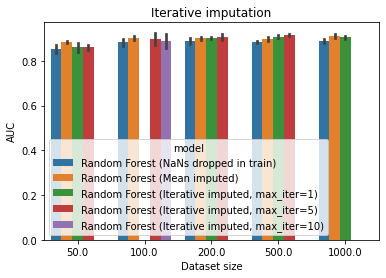

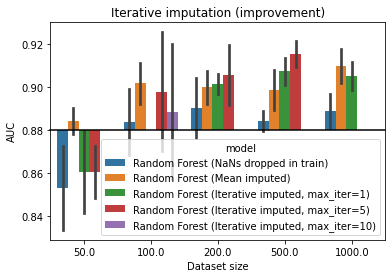

In [4]:
title = "Iterative imputation"

base_all = ['outputs/model-evaluations-20230519-223940-GILGFVFTL-50-fixed-test-size/scores-20230519-224017.csv',
                  'outputs/model-evaluations-20230519-223724-GILGFVFTL-100-fixed-test-size/scores-20230519-223817.csv',
                  'outputs/model-evaluations-20230518-133505-GILGFVFTL-200-fixed-test-size/scores-20230518-133605.csv',
                  'outputs/model-evaluations-20230518-133659-GILGFVFTL-500-fixed-test-size/scores-20230518-133906.csv',
                  'outputs/model-evaluations-20230518-134125-GILGFVFTL-1000-fixed-test-size/scores-20230518-134633.csv',
                  'outputs/model-evaluations-20230518-134717-GILGFVFTL-2000-fixed-test-size/scores-20230518-140119.csv',
                  'outputs/model-evaluations-20230519-011756-GILGFVFTL-5000-fixed-test-size/scores-20230519-024251.csv',
                  'outputs/model-evaluations-20230519-090347-GILGFVFTL-12528-fixed-test-size/scores-20230519-202428.csv']

iterative_results = [
    'outputs/model-evaluations-20230521-200717-GILGFVFTL-50--iterative-imputers/1-Random Forest (Iterative imputed, max_iter=1).csv',
    'outputs/model-evaluations-20230521-200717-GILGFVFTL-50--iterative-imputers/2-Random Forest (Iterative imputed, max_iter=5).csv',

    'outputs/model-evaluations-20230521-202243-GILGFVFTL-100--iterative-imputers/2-Random Forest (Iterative imputed, max_iter=5).csv',
    'outputs/model-evaluations-20230521-202243-GILGFVFTL-100--iterative-imputers/3-Random Forest (Iterative imputed, max_iter=10).csv',

    'outputs/model-evaluations-20230522-071321-GILGFVFTL-200--iterative-imputers/scores-20230522-072955.csv',

    'outputs/model-evaluations-20230522-073856-GILGFVFTL-500--iterative-imputers/scores-20230522-084148.csv',

    'outputs/model-evaluations-20230522-155837-GILGFVFTL-1000--iterative-imputers/1-Random Forest (Iterative imputed, max_iter=1).csv']

df = compose_all(base_all + iterative_results,
                 None,
                 models_to_keep=["Random Forest (NaNs dropped in train)",
                                 "Random Forest (Mean imputed)",
                                 "Random Forest (Iterative imputed, max_iter=1)",
                                 "Random Forest (Iterative imputed, max_iter=5)",
                                 "Random Forest (Iterative imputed, max_iter=10)"],
                 attributes_to_keep={'df_size': [50, 100, 200, 500, 1000]})

output = 'graphs/GILGFVFTL-iterative-imputers.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)

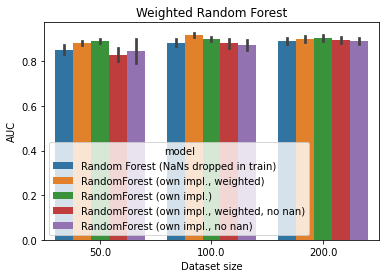

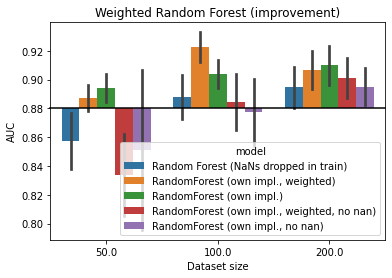

In [5]:
title = "Weighted Random Forest"

df = compose_all(base_all + ['outputs/model-evaluations-20230522-203946-GILGFVFTL-50-weighted-rf/scores-20230522-204407.csv',
                             'outputs/model-evaluations-20230522-204411-GILGFVFTL-100-weighted-rf/scores-20230522-205100.csv',
                             'outputs/model-evaluations-20230522-205105-GILGFVFTL-200-weighted-rf/scores-20230522-211114.csv'],
                 None,
                 models_to_keep=["Random Forest (NaNs dropped in train)",
                                 "RandomForest (own impl., weighted)",
                                 "RandomForest (own impl.)",
                                 "RandomForest (own impl., no nan)",
                                 "RandomForest (own impl., weighted, no nan)"],
                    attributes_to_keep={'df_size': [50, 100, 200]})

output = 'graphs/GILGFVFTL-weighted-rf.png'
plot_scores(df, title, wrap=True, x="df_size", hue="model", xlabel="Dataset size", ylabel="AUC", output_file=output,
            plot=True)